<a href="https://colab.research.google.com/github/shreesha2304/NYC-Taxi-Trip-Time-Prediction/blob/main/NYC_Taxi_Trip_Time_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

In [2]:
#importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import datetime
import datetime as dt
from geopy.distance import  great_circle
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import  r2_score, mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [34]:
#reading the dataset
df=pd.read_csv('/content/drive/MyDrive/AlmaBetter/Capstone Project 2/NYC Taxi Data.csv')

In [35]:
#examining the head of the dataset
df.head()

id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.765602                  N            455  
1         40.731152                  N            663  
2         40.710087                  N           2124  
3         40.706718                  N            429  
4         40.782520                  N            435

In [36]:
#checking the dimentions of the dataset
df.shape

(1458644, 11)

We can observe that the given dataset consists of 1458644 rows and 11 columns

In [8]:
#finding out the total observations available in the dataset
df.size

16045084

In [9]:
#finding out the basic information regarding the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [10]:
#checking the column names
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

In [37]:
#getting the numerical features corresponding to numeric columns
df.describe().T


count        mean          std         min         25%  \
vendor_id          1458644.0    1.534950     0.498777    1.000000    1.000000   
passenger_count    1458644.0    1.664530     1.314242    0.000000    1.000000   
pickup_longitude   1458644.0  -73.973486     0.070902 -121.933342  -73.991867   
pickup_latitude    1458644.0   40.750921     0.032881   34.359695   40.737347   
dropoff_longitude  1458644.0  -73.973416     0.070643 -121.933304  -73.991325   
dropoff_latitude   1458644.0   40.751800     0.035891   32.181141   40.735885   
trip_duration      1458644.0  959.492273  5237.431724    1.000000  397.000000   

                          50%          75%           max  
vendor_id            2.000000     2.000000  2.000000e+00  
passenger_count      1.000000     2.000000  9.000000e+00  
pickup_longitude   -73.981743   -73.967331 -6.133553e+01  
pickup_latitude     40.754101    40.768360  5.188108e+01  
dropoff_longitude  -73.979752   -73.963013 -6.133553e+01  
dropoff_latitude    40.754524    40.769810  4.392103e+01  
trip_duration      662.000000  1075.000000  3.526282e+06

In [38]:
#checking for any null values
df.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

From the information above, we observe that there are no null values in the dataset. Hence it is not required to clean the data or handle null values.

In [39]:
#checking for duplicated rows
df.duplicated().sum()

0

There are no duplicate entries.

In [40]:
#converting the object data involving datetime into datettime format
df['pickup_datetime']=pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime']=pd.to_datetime(df['dropoff_datetime'])

# **CATEGORICAL FEATURES AND ANALYSIS**

vendor_id and store_and_fwd_flag are the categorical variables in this dataset. We need to observe how do these variables relate to the total number of trips.

Text(0.5, 1.0, 'count vs vendor_id graph')

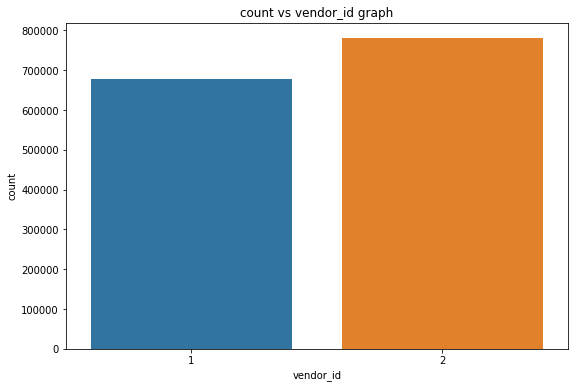

In [41]:
#plotting vendor_id and count of trips
plt.figure(figsize=(9,6))
sns.countplot(data=df,x='vendor_id')
plt.title('count vs vendor_id graph')

From the plot, it is evident that among the two vendors, vendor with id 2 has taken more number of trips.

Text(0.5, 1.0, 'count vs store_and_fwd_flag graph')

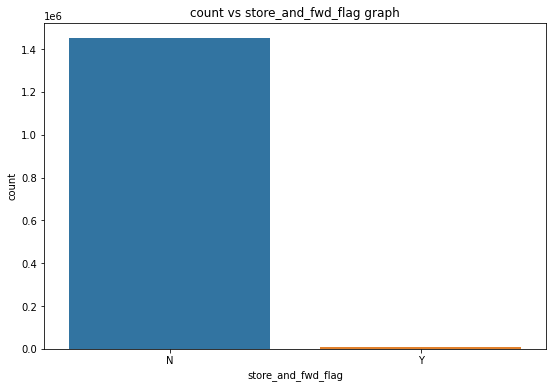

In [42]:
#plotting store_and_fwd_flag and count plot
plt.figure(figsize=(9,6))
sns.countplot(data=df,x='store_and_fwd_flag')
plt.title('count vs store_and_fwd_flag graph')

From the plot, it can be seen that most of the trips were of store_and_fwd_flag NO type.

In the project, we need to find the relationship between dependent variable trip duration and other independent input variables. We need to find how the trip_duration is distributed and check it's skewness.

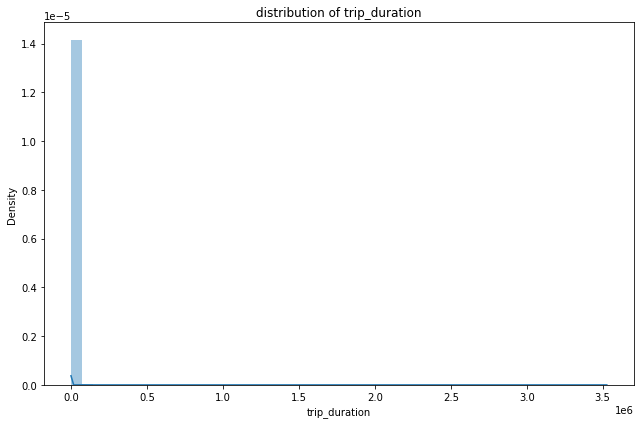

In [43]:
#distribution of trip_duration
plt.figure(figsize=(9,6))
sns.distplot((df['trip_duration']))
plt.title('distribution of trip_duration')
plt.tight_layout()


In [44]:
#skewness of trip_duration
df['trip_duration'].skew()

343.1639435917362

As we can see, the trip duration has a large positive skewness implying that most of the values are concentrated around the left tail. In order to reduce that, we can take the logarithm of trip_duration.

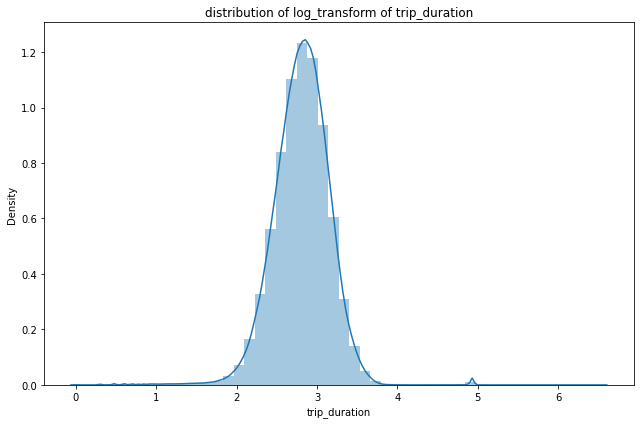

In [45]:
#checking the distribution of log of trip_duration
plt.figure(figsize=(9,6))
sns.distplot(np.log10(df['trip_duration']))
plt.title('distribution of log_transform of trip_duration')
plt.tight_layout()

In [46]:
#checking the skewness
np.log10(df['trip_duration']).skew()

-0.34070423044800024

From the plot and the skewness value, it can be treated as almost normally distributed.

In [47]:
#checking the information regarding trip_duration
df['trip_duration'].describe()

count    1.458644e+06
mean     9.594923e+02
std      5.237432e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64

Text(0.5, 1.0, 'trips and number of passengers')

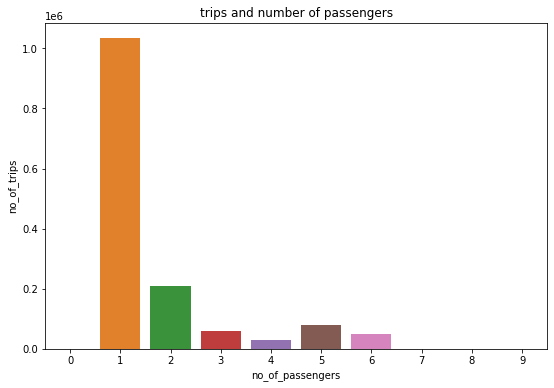

In [48]:
#plotting the graph to understand the relationship between the no of passengers and no of trips
plt.figure(figsize=(9,6))
sns.countplot(data=df,x='passenger_count')
plt.xlabel('no_of_passengers')
plt.ylabel('no_of_trips')
plt.title('trips and number of passengers')


It can be observed that most people travel alone.

In [49]:
#information regarding passenger_count
df['passenger_count'].describe()

count    1.458644e+06
mean     1.664530e+00
std      1.314242e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      9.000000e+00
Name: passenger_count, dtype: float64

Text(0.5, 1.0, 'Pickups')

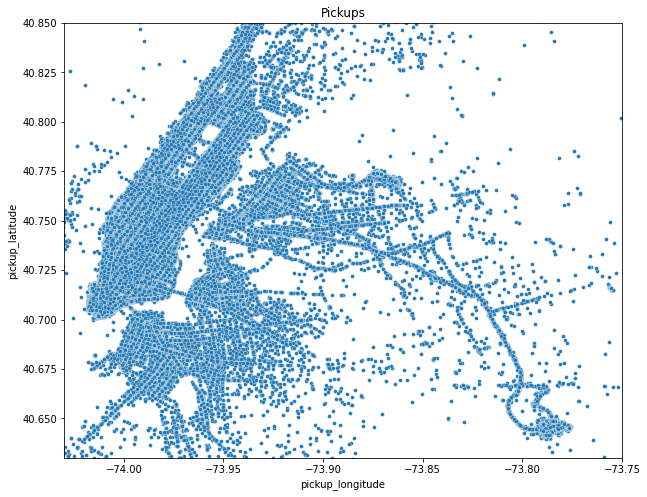

In [50]:
#visualizing the pickup points by using latitude and longitude
plt.figure(figsize=(10,8))
long_limit=[-74.03, -73.75]
lat_limit=[40.63,40.85]
sns.scatterplot(x='pickup_longitude',y='pickup_latitude', data=df,s=15)
plt.xlim(long_limit)
plt.ylim(lat_limit)
plt.title('Pickups')

Text(0.5, 1.0, 'Dropoffs')

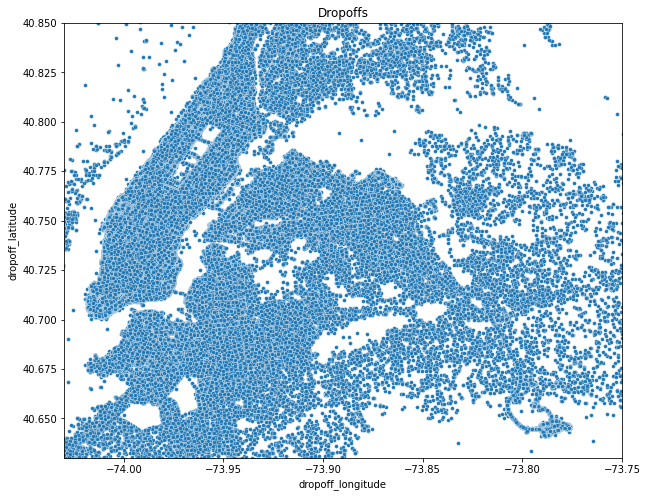

In [51]:
#visualizing the dropoff points by using latitude and longitude
plt.figure(figsize=(10,8))
long_limit=[-74.03, -73.75]
lat_limit=[40.63,40.85]
sns.scatterplot(x='dropoff_longitude',y='dropoff_latitude', data=df,s=15)
plt.xlim(long_limit)
plt.ylim(lat_limit)
plt.title('Dropoffs')

In [52]:
#visualizing the starting and end points by using folium
import folium
fig = folium.Figure(width=1500, height=500)
map1 = folium.Map(location = (40.63, -73.75), zoom_start=10).add_to(fig)

for index, row in df.sample(500).iterrows():
    folium.Marker([row["pickup_latitude"], row["pickup_longitude"]], icon=folium.Icon(color="green")).add_to(map1)
    folium.Marker([row["dropoff_latitude"], row["dropoff_longitude"]], icon=folium.Icon(color="red")).add_to(map1)
display(map1)

We need to calculate the distance travelled in each trip. It can be obtained by making use of latitude and longitude provided in the dataset. By using the *Great Circle Method*, We can calculate the travel distance.

In [53]:
#calculate the distances
def calc_distance(row):
  coord_1 = (row['pickup_latitude'], row['pickup_longitude'])
  coord_2 = (row['dropoff_latitude'], row['dropoff_longitude'])
  return great_circle(coord_1, coord_2).km

df['distance'] = df.apply(calc_distance, axis=1)

In [ ]:
df

id  vendor_id     pickup_datetime    dropoff_datetime  \
0        id2875421          2 2016-03-14 17:24:55 2016-03-14 17:32:30   
1        id2377394          1 2016-06-12 00:43:35 2016-06-12 00:54:38   
2        id3858529          2 2016-01-19 11:35:24 2016-01-19 12:10:48   
3        id3504673          2 2016-04-06 19:32:31 2016-04-06 19:39:40   
4        id2181028          2 2016-03-26 13:30:55 2016-03-26 13:38:10   
...            ...        ...                 ...                 ...   
1458639  id2376096          2 2016-04-08 13:31:04 2016-04-08 13:44:02   
1458640  id1049543          1 2016-01-10 07:35:15 2016-01-10 07:46:10   
1458641  id2304944          2 2016-04-22 06:57:41 2016-04-22 07:10:25   
1458642  id2714485          1 2016-01-05 15:56:26 2016-01-05 16:02:39   
1458643  id1209952          1 2016-04-05 14:44:25 2016-04-05 14:47:43   

         passenger_count  pickup_longitude  pickup_latitude  \
0                      1        -73.982155        40.767937   
1                      1        -73.980415        40.738564   
2                      1        -73.979027        40.763939   
3                      1        -74.010040        40.719971   
4                      1        -73.973053        40.793209   
...                  ...               ...              ...   
1458639                4        -73.982201        40.745522   
1458640                1        -74.000946        40.747379   
1458641                1        -73.959129        40.768799   
1458642                1        -73.982079        40.749062   
1458643                1        -73.979538        40.781750   

         dropoff_longitude  dropoff_latitude store_and_fwd_flag  \
0               -73.964630         40.765602                  N   
1               -73.999481         40.731152                  N   
2               -74.005333         40.710087                  N   
3               -74.012268         40.706718                  N   
4               -73.972923         40.782520                  N   
...                    ...               ...                ...   
1458639         -73.994911         40.740170                  N   
1458640         -73.970184         40.796547                  N   
1458641         -74.004433         40.707371                  N   
1458642         -73.974632         40.757107                  N   
1458643         -73.972809         40.790585                  N   

         trip_duration  distance  
0                  455  1.498523  
1                  663  1.805510  
2                 2124  6.385108  
3                  429  1.485501  
4                  435  1.188590  
...                ...       ...  
1458639            778  1.225082  
1458640            655  6.049844  
1458641            764  7.824617  
1458642            373  1.092565  
1458643            198  1.134044  

[1458644 rows x 12 columns]

In [54]:
#segregating the numerical featuers
num_features=['passenger_count','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','distance','trip_duration']

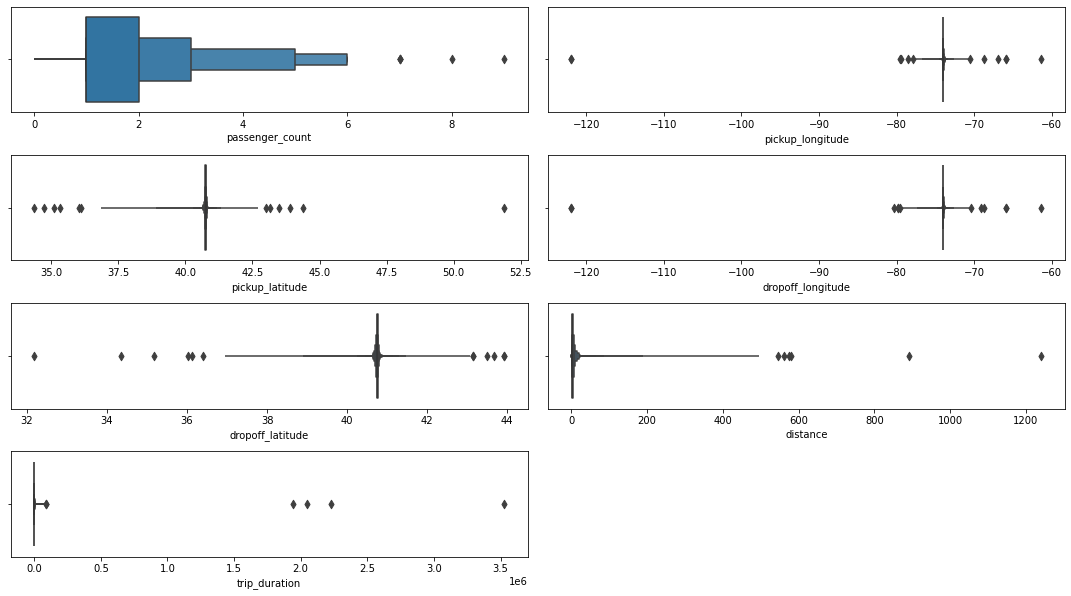

In [55]:
#plotting boxenplots to find the distribution of these features
plt.figure(figsize=(15,10))
n =1
for i in num_features:
  plt.subplot(5,2,n)
  sns.boxenplot(df[i])
  n+=1
plt.tight_layout()


From the plots, it is obvious that all the variables have a lot of outliers which can affect the further analysis. 

In [56]:
#check the duration of most number of trips
labels=['within 10 sec','between 10 sec and 1 min','between 1 min and 10 min','between 10 min and 1 hr','between 1 hr and 1 day','between 1 day and 2 day','more than 2 day'  ]
duration=pd.DataFrame(pd.cut(df.trip_duration, [1,10,60,600,3600,86400,172800,3530000],labels=labels )).reset_index().rename(columns={'index':'number'})
time_data=pd.DataFrame(duration.groupby('trip_duration').number.count().reset_index())


Text(0.5, 1.0, 'no_of_trips vs duration')

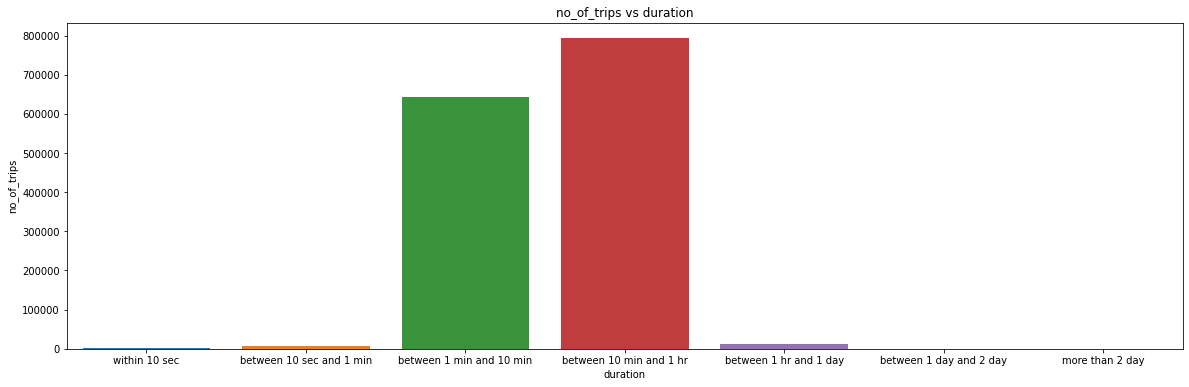

In [57]:
plt.figure(figsize=(20,6))
sns.barplot(time_data['trip_duration'],time_data['number'])
plt.xlabel('duration')
plt.ylabel('no_of_trips')
plt.title('no_of_trips vs duration')

From the plot, it is inferred that most of the trips are within 1 min and 1 hr duration. There are only few trips exceeding or preceding these durations.

We need to remove outliers. For the sake of outlier removal, we use inter-quartile ranges.

In [58]:
#percentiles for distance
q1 = np.percentile(df['distance'],25)
print(q1)
q2 = np.percentile(df['distance'],50)
print(q2)
q3 = np.percentile(df['distance'],75)
print(q3)


1.2318383063623233
2.0937200906182802
3.8753428927314006


In [59]:
#defining iqr
iqr=q3 -q1
llimit=q1-(1.5*iqr)
ulimit=q3+(1.5*iqr)

print("lower limit for outlier  :",llimit)
print("Upper limit for outlier  :",ulimit)

lower limit for outlier  : -2.7334185731912926
Upper limit for outlier  : 7.8405997722850165


In [60]:
#Considering only those values falling between the necessary range
df=df[df['distance']>llimit]
df=df[df['distance']<ulimit]

In [61]:
#removal of outliers for trip_duration
q1 = np.percentile(df['trip_duration'],25)
print(q1)
q2 = np.percentile(df['trip_duration'],50)
print(q2)
q3 = np.percentile(df['trip_duration'],75)
print(q3)


373.0
605.0
931.0


In [62]:
iqr=q3 -q1
llimit=q1-(1.5*iqr)
ulimit=q3+(1.5*iqr)
print("lower limit for outlier  :",llimit)
print("Upper limit for outlier  :",ulimit)

lower limit for outlier  : -464.0
Upper limit for outlier  : 1768.0


In [63]:
df=df[df['trip_duration']>llimit]
df=df[df['trip_duration']<ulimit]

In [64]:
#removing outliers from passenger_count as well
q1 = np.percentile(df['passenger_count'],25)
print(q1)
q2 = np.percentile(df['passenger_count'],50)
print(q2)
q3 = np.percentile(df['passenger_count'],75)
print(q3)

1.0
1.0
2.0


In [65]:
iqr=q3 -q1
llimit=q1-(1.5*iqr)
ulimit=q3+(1.5*iqr)
print("lower limit for outlier  :",llimit)
print("Upper limit for outlier  :",ulimit)

lower limit for outlier  : -0.5
Upper limit for outlier  : 3.5


In [66]:
df=df[df['passenger_count']>llimit]
df=df[df['passenger_count']<ulimit]

The entire New York City falls between  -74.03 and -73.75 longitudes and Latitudes are 40.63 N and 40.85 N. Any latitude or longitude other than these values are not to be considered.

In [67]:
#extracting the values falling within city limit
df = df[df['pickup_longitude'] <= -73.75]
df = df[df['pickup_longitude'] >= -74.03]
df = df[df['pickup_latitude'] <= 40.85]
df = df[df['pickup_latitude'] >= 40.63]
df = df[df['dropoff_longitude'] <= -73.75]
df = df[df['dropoff_longitude'] >= -74.03]
df = df[df['dropoff_latitude'] <= 40.85]
df = df[df['dropoff_latitude'] >= 40.63]

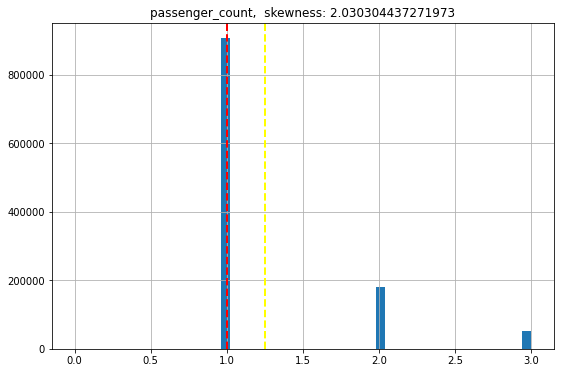

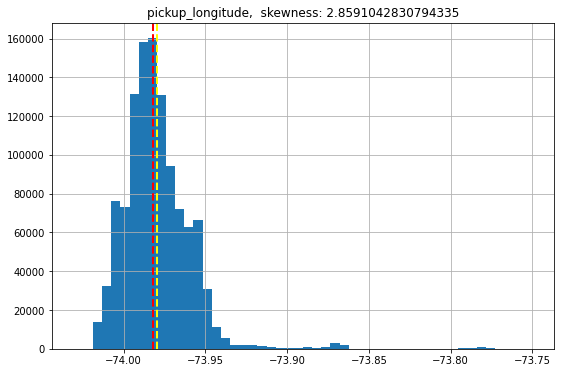

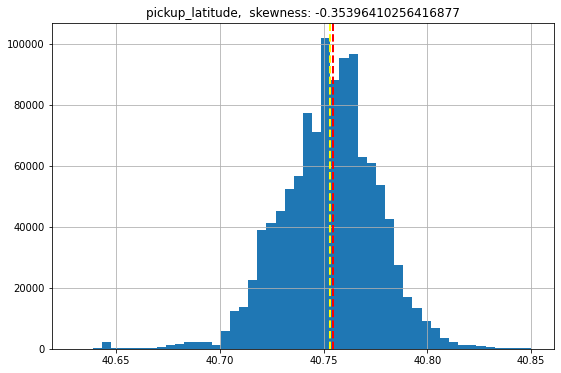

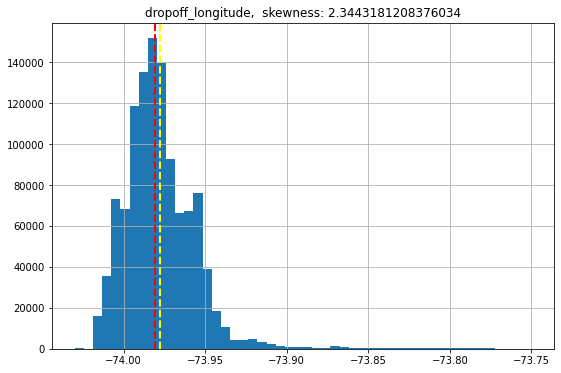

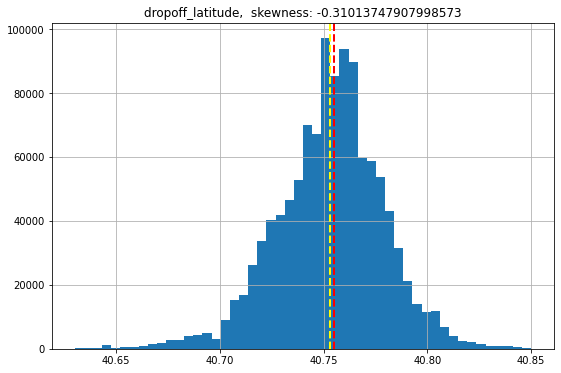

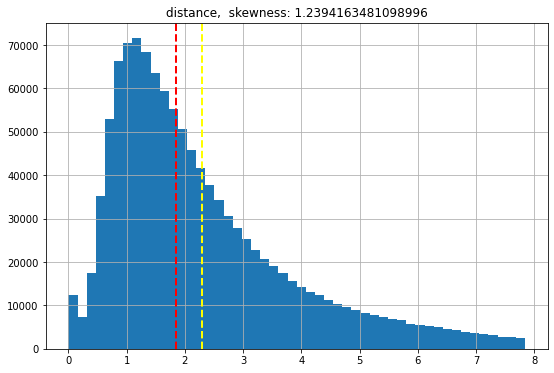

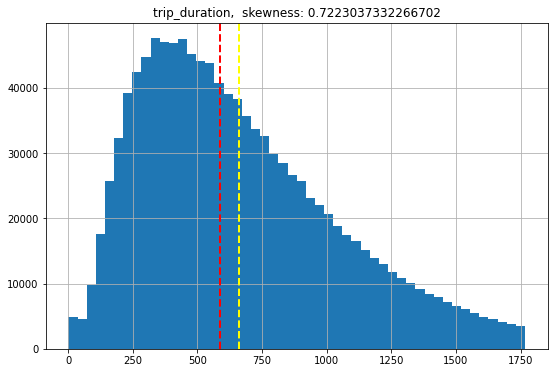

In [68]:
#after removing outliers, we plot the histograms for all variables and find out their skewness as well.
for i in num_features:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = df[i]
    feature.hist(bins=50, ax = ax)
    ax.axvline(feature.mean(), color='yellow', linestyle='dashed', linewidth=2)
    ax.axvline(feature.median(), color='red', linestyle='dashed', linewidth=2)    
    ax.set_title(i+', '+ ' skewness: ' +str(df[i].skew()))
plt.show()

For the simplification of further processing, we extract tha datetime features separately.

In [69]:
df['month']=df['pickup_datetime'].dt.month
df['pickup_dayname']=df['pickup_datetime'].dt.day_name()
df['dropoff_dayname']=df['dropoff_datetime'].dt.day_name()
df['pickup_date']=df['pickup_datetime'].dt.day
df['pickup_hr']=df['pickup_datetime'].dt.hour
df['pickup_min']=df['pickup_datetime'].dt.minute
df['pickup_sec']=df['pickup_datetime'].dt.second


In [ ]:
df

id  vendor_id     pickup_datetime    dropoff_datetime  \
0        id2875421          2 2016-03-14 17:24:55 2016-03-14 17:32:30   
1        id2377394          1 2016-06-12 00:43:35 2016-06-12 00:54:38   
2        id3858529          2 2016-01-19 11:35:24 2016-01-19 12:10:48   
3        id3504673          2 2016-04-06 19:32:31 2016-04-06 19:39:40   
4        id2181028          2 2016-03-26 13:30:55 2016-03-26 13:38:10   
...            ...        ...                 ...                 ...   
1458637  id1920898          1 2016-04-17 18:48:16 2016-04-17 19:00:56   
1458640  id1049543          1 2016-01-10 07:35:15 2016-01-10 07:46:10   
1458641  id2304944          2 2016-04-22 06:57:41 2016-04-22 07:10:25   
1458642  id2714485          1 2016-01-05 15:56:26 2016-01-05 16:02:39   
1458643  id1209952          1 2016-04-05 14:44:25 2016-04-05 14:47:43   

         passenger_count  pickup_longitude  pickup_latitude  \
0                      1        -73.982155        40.767937   
1                      1        -73.980415        40.738564   
2                      1        -73.979027        40.763939   
3                      1        -74.010040        40.719971   
4                      1        -73.973053        40.793209   
...                  ...               ...              ...   
1458637                1        -73.975357        40.751705   
1458640                1        -74.000946        40.747379   
1458641                1        -73.959129        40.768799   
1458642                1        -73.982079        40.749062   
1458643                1        -73.979538        40.781750   

         dropoff_longitude  dropoff_latitude store_and_fwd_flag  \
0               -73.964630         40.765602                  N   
1               -73.999481         40.731152                  N   
2               -74.005333         40.710087                  N   
3               -74.012268         40.706718                  N   
4               -73.972923         40.782520                  N   
...                    ...               ...                ...   
1458637         -73.949478         40.776764                  N   
1458640         -73.970184         40.796547                  N   
1458641         -74.004433         40.707371                  N   
1458642         -73.974632         40.757107                  N   
1458643         -73.972809         40.790585                  N   

         trip_duration  distance  month pickup_dayname dropoff_dayname  \
0                  455  1.498523      3         Monday          Monday   
1                  663  1.805510      6         Sunday          Sunday   
2                 2124  6.385108      1        Tuesday         Tuesday   
3                  429  1.485501      4      Wednesday       Wednesday   
4                  435  1.188590      3       Saturday        Saturday   
...                ...       ...    ...            ...             ...   
1458637            760  3.537560      4         Sunday          Sunday   
1458640            655  6.049844      1         Sunday          Sunday   
1458641            764  7.824617      4         Friday          Friday   
1458642            373  1.092565      1        Tuesday         Tuesday   
1458643            198  1.134044      4        Tuesday         Tuesday   

         pickup_date  pickup_hr  
0                 14         17  
1                 12          0  
2                 19         11  
3                  6         19  
4                 26         13  
...              ...        ...  
1458637           17         18  
1458640           10          7  
1458641           22          6  
1458642            5         15  
1458643            5         14  

[1175345 rows x 17 columns]

Text(0.5, 1.0, 'no_of_trips vs month')

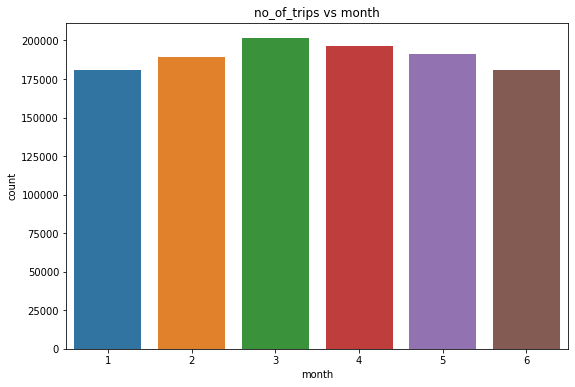

In [70]:
#plotting the no of trips in different months
plt.figure(figsize=(9,6))
sns.countplot(x='month',data=df)
plt.title('no_of_trips vs month')

It is seen that most no of trips occurn in the month of March.

Text(0.5, 1.0, 'no_of_trips vs pickup_day')

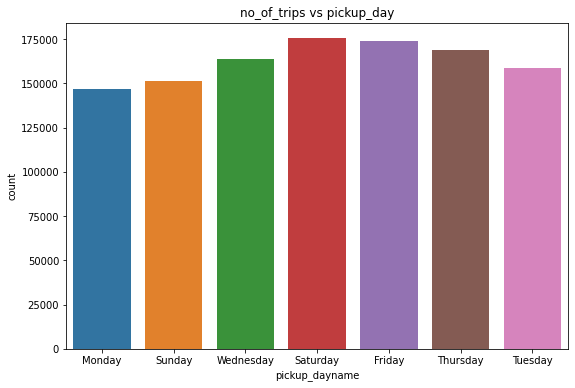

In [71]:
#plotting the graph
plt.figure(figsize=(9,6))
sns.countplot(x='pickup_dayname',data=df)
plt.title('no_of_trips vs pickup_day')

It can be observed that most number of trips happen in Saturday, Followed by Friday.

In [72]:
#observing the count of trips in different parts of month
labels=['first_week','second_week','third_week','fourth_week']
new=pd.DataFrame(pd.cut(df.pickup_date, [1,7,14,21,31],labels=labels )).reset_index().rename(columns={'index':'number'})
week=pd.DataFrame(new['pickup_date'].value_counts().reset_index())
week

index  pickup_date
0  fourth_week       333430
1  second_week       270552
2   third_week       268391
3   first_week       230987

Text(0.5, 1.0, 'count of trips in different weeks')

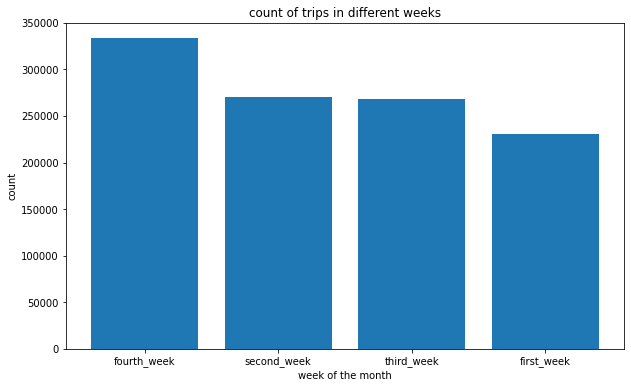

In [80]:
#plotting the graph
plt.figure(figsize=(10,6))
plt.bar(x=week['index'],height=week['pickup_date'])
plt.xlabel('week of the month')
plt.ylabel('count')
plt.title('count of trips in different weeks')

It is noted that most trips occur in the last week of month. Least number of trips occur in the first_week.

In [79]:
#defining a function to classify the days into weekdays and weekends
def weekday_or_end(x):
  if x in ['Monday','Tuesday','Wednesday','Thursday','Friday']:
    return 'weekday'
  else:
    return 'weekend'


df['weekday_or_end']=df['pickup_dayname'].apply(weekday_or_end)


In [ ]:
df

id  vendor_id     pickup_datetime    dropoff_datetime  \
0        id2875421          2 2016-03-14 17:24:55 2016-03-14 17:32:30   
1        id2377394          1 2016-06-12 00:43:35 2016-06-12 00:54:38   
3        id3504673          2 2016-04-06 19:32:31 2016-04-06 19:39:40   
4        id2181028          2 2016-03-26 13:30:55 2016-03-26 13:38:10   
7        id1324603          2 2016-05-21 07:54:58 2016-05-21 08:20:49   
...            ...        ...                 ...                 ...   
1458637  id1920898          1 2016-04-17 18:48:16 2016-04-17 19:00:56   
1458640  id1049543          1 2016-01-10 07:35:15 2016-01-10 07:46:10   
1458641  id2304944          2 2016-04-22 06:57:41 2016-04-22 07:10:25   
1458642  id2714485          1 2016-01-05 15:56:26 2016-01-05 16:02:39   
1458643  id1209952          1 2016-04-05 14:44:25 2016-04-05 14:47:43   

         passenger_count  pickup_longitude  pickup_latitude  \
0                      1        -73.982155        40.767937   
1                      1        -73.980415        40.738564   
3                      1        -74.010040        40.719971   
4                      1        -73.973053        40.793209   
7                      1        -73.969276        40.797779   
...                  ...               ...              ...   
1458637                1        -73.975357        40.751705   
1458640                1        -74.000946        40.747379   
1458641                1        -73.959129        40.768799   
1458642                1        -73.982079        40.749062   
1458643                1        -73.979538        40.781750   

         dropoff_longitude  dropoff_latitude  trip_duration  \
0               -73.964630         40.765602            455   
1               -73.999481         40.731152            663   
3               -74.012268         40.706718            429   
4               -73.972923         40.782520            435   
7               -73.922470         40.760559           1551   
...                    ...               ...            ...   
1458637         -73.949478         40.776764            760   
1458640         -73.970184         40.796547            655   
1458641         -74.004433         40.707371            764   
1458642         -73.974632         40.757107            373   
1458643         -73.972809         40.790585            198   

         store_and_fwd_flag  distance  month pickup_dayname dropoff_dayname  \
0                         0  1.498523      3         Monday          Monday   
1                         0  1.805510      6         Sunday          Sunday   
3                         0  1.485501      4      Wednesday       Wednesday   
4                         0  1.188590      3       Saturday        Saturday   
7                         0  5.714989      5       Saturday        Saturday   
...                     ...       ...    ...            ...             ...   
1458637                   0  3.537560      4         Sunday          Sunday   
1458640                   0  6.049844      1         Sunday          Sunday   
1458641                   0  7.824617      4         Friday          Friday   
1458642                   0  1.092565      1        Tuesday         Tuesday   
1458643                   0  1.134044      4        Tuesday         Tuesday   

         pickup_date  pickup_hr weekday_or_end  
0                 14         17        weekday  
1                 12          0        weekend  
3                  6         19        weekday  
4                 26         13        weekend  
7                 21          7        weekend  
...              ...        ...            ...  
1458637           17         18        weekend  
1458640           10          7        weekend  
1458641           22          6        weekday  
1458642            5         15        weekday  
1458643            5         14        weekday  

[1139517 rows x 18 columns]

Text(0.5, 1.0, 'trip_duration_in_weekday or weekend')

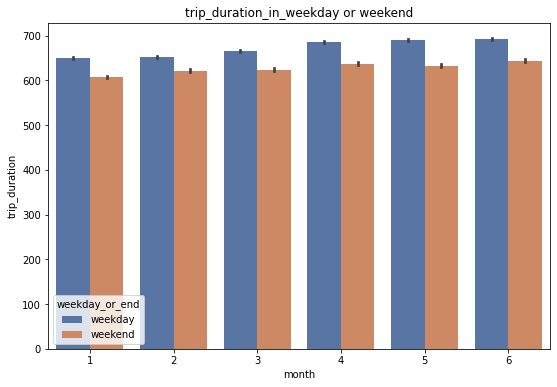

In [81]:
#plotting the graph
plt.figure(figsize=(9,6))
sns.barplot(data=df,x='month',y='trip_duration',hue='weekday_or_end',palette="deep")
plt.title('trip_duration_in_weekday or weekend')

It is evident that in weekends the trip duration is less, which is applicable for all the months.

Text(0.5, 1.0, 'duration vs day')

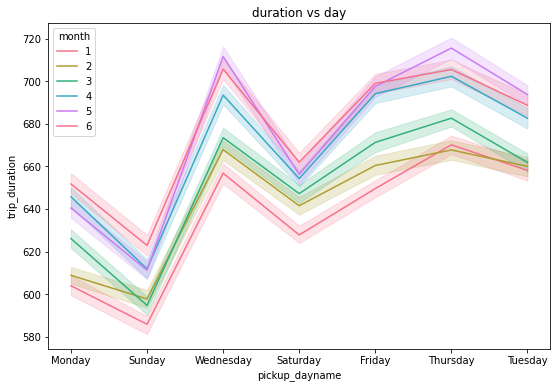

In [82]:
#finding the relationship between duration vs day
plt.figure(figsize=(9,6))
sns.lineplot(x='pickup_dayname',y='trip_duration',hue='month',palette='husl',data=df)
plt.title('duration vs day')

The above graph justifies the previous observation. On saturdays and Sundays trip duration is less. In terms of month, Januray has the least duration and May has max duration.

In [84]:
#finding different parts of a day
def time_period(x):
  if x>=0 and x<6:
    return 'early_morning'
  if x>=6 and x<12:
    return 'morning'
  if x>=12 and x<16:
    return 'afternoon'
  if x>=16 and x<20:
    return 'evening'
  else:
    return 'night'


In [85]:
df['time_period']=df['pickup_hr'].apply(time_period)

Text(0.5, 1.0, 'duration in different parts of day')

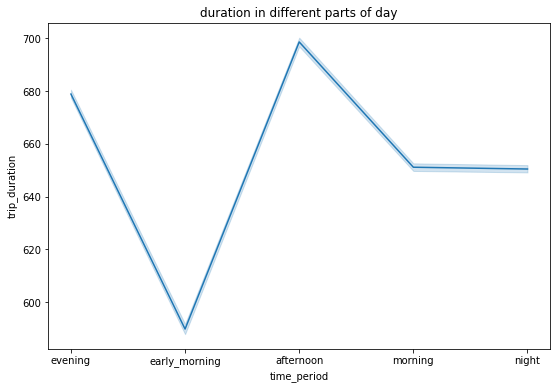

In [ ]:
#plotting the relationship between duration and different parts of day
plt.figure(figsize=(9,6))
sns.lineplot(x='time_period',y='trip_duration',data=df)
plt.title('duration in different parts of day')


It can be found that in the early morning trip duration is less, whereas in the afternoon, trip duration is the highest.

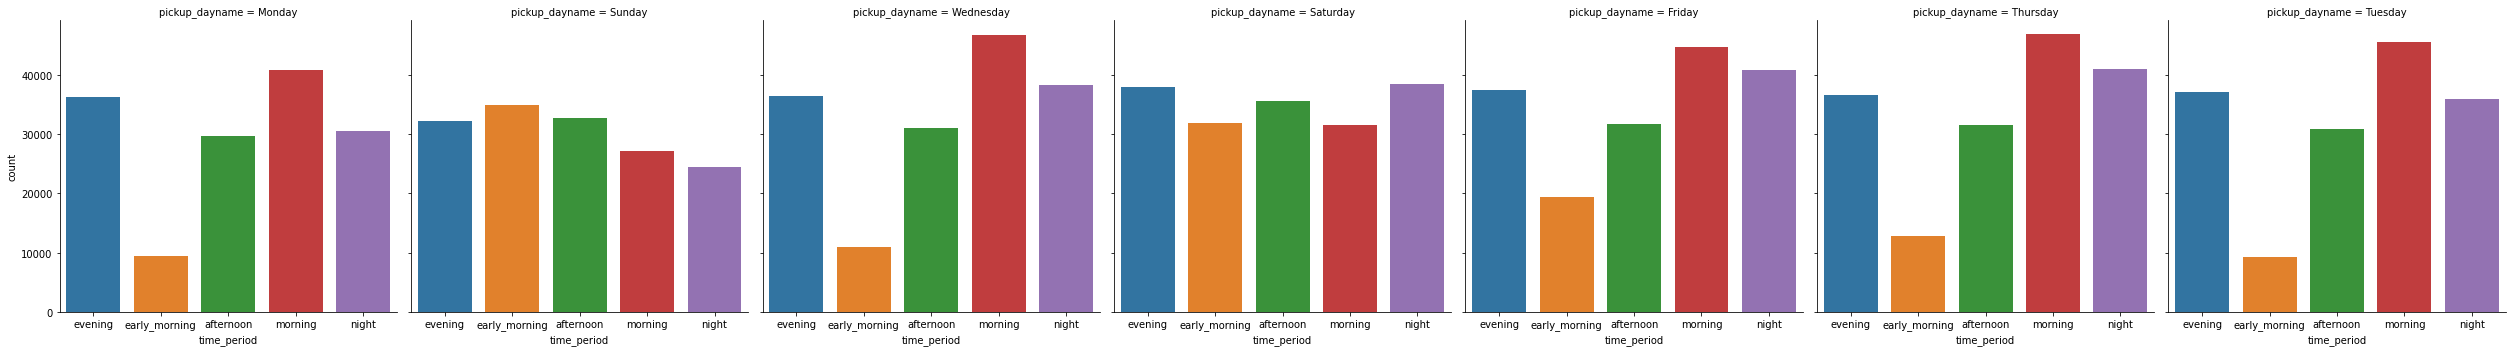

In [ ]:
#count vs different days and times
sns.catplot(data=df,kind='count',x='time_period',col='pickup_dayname');
plt.tight_layout()

In all other days except sunday, no of trips is lesser in early morning. 

Text(0.5, 1.0, 'distance in different hours')

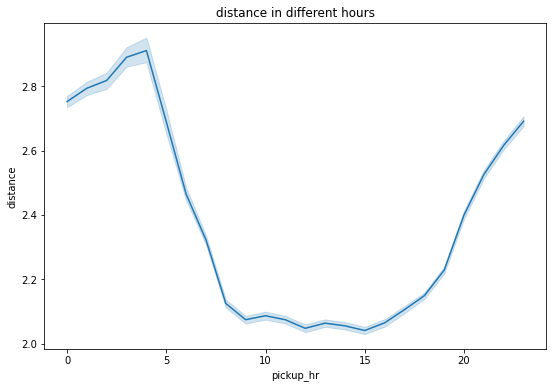

In [ ]:
#distance in diff hours vs hour
plt.figure(figsize=(9,6))
sns.lineplot(data=df,y='distance',x='pickup_hr')
plt.title('distance in different hours')

5 AM is the time at which the longer trips are commenced.

Text(0.5, 1.0, 'Distance and Vendor id')

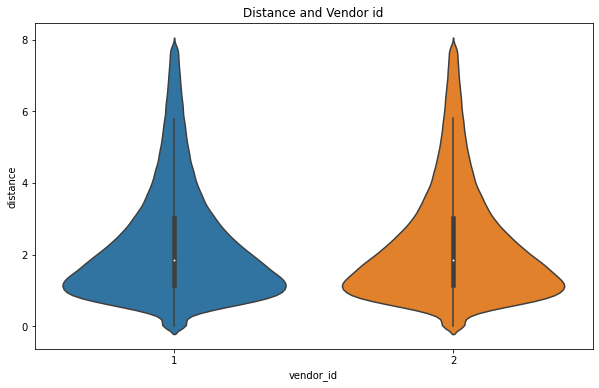

In [35]:
plt.figure(figsize=(10,6))
sns.violinplot(x='vendor_id', y='distance',data=df)
plt.title('Distance and Vendor id')
                  

Text(0.5, 1.0, 'storage state and Vendor id')

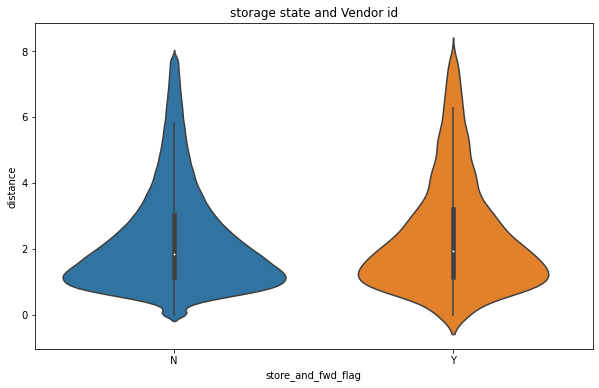

In [36]:
plt.figure(figsize=(10,6))
sns.violinplot(x='store_and_fwd_flag', y='distance',data=df)
plt.title('storage state and Vendor id')

It is evident that for both vendor id, the distribution is almost similar.

In [86]:
#taking log of both trip_duration and distance
df['log_trip_duration']=np.log10(df['trip_duration'])
df['log_of_distance']=np.log10(df['distance'])

Text(0.5, 1.0, 'Distribution of distance')

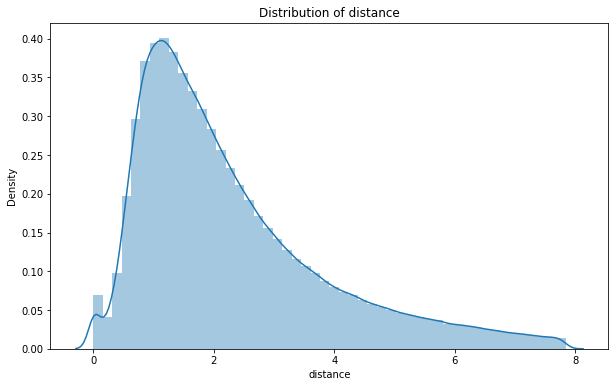

In [24]:
plt.figure(figsize=(10,6))
sns.distplot(df['distance'])
plt.title('Distribution of distance')


In [87]:
#converting store_and_fwd_flag into numeric values using encoding
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].map(dict(N=0,Y=1))

In [88]:
#getting dummy values for month and pickup_dayname
df = pd.get_dummies(df ,columns= ['month','pickup_dayname'],drop_first=True)


In [89]:
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'distance', 'dropoff_dayname', 'pickup_date',
       'pickup_hr', 'pickup_min', 'pickup_sec', 'weekday_or_end',
       'time_period', 'log_trip_duration', 'log_of_distance', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'pickup_dayname_Monday',
       'pickup_dayname_Saturday', 'pickup_dayname_Sunday',
       'pickup_dayname_Thursday', 'pickup_dayname_Tuesday',
       'pickup_dayname_Wednesday'],
      dtype='object')

In [90]:
#dropping those columuns we have created just for analysis and not necessary to train the model
df.drop(['id','pickup_datetime','dropoff_datetime','trip_duration','dropoff_datetime','dropoff_dayname','weekday_or_end','log_of_distance','time_period'],axis=1,inplace=True)
# df.drop(['time_period'],axis=1,inplace=True)

In [41]:
df.columns

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'distance', 'pickup_date', 'pickup_hr', 'pickup_min', 'pickup_sec',
       'log_trip_duration', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'pickup_dayname_Monday', 'pickup_dayname_Saturday',
       'pickup_dayname_Sunday', 'pickup_dayname_Thursday',
       'pickup_dayname_Tuesday', 'pickup_dayname_Wednesday'],
      dtype='object')

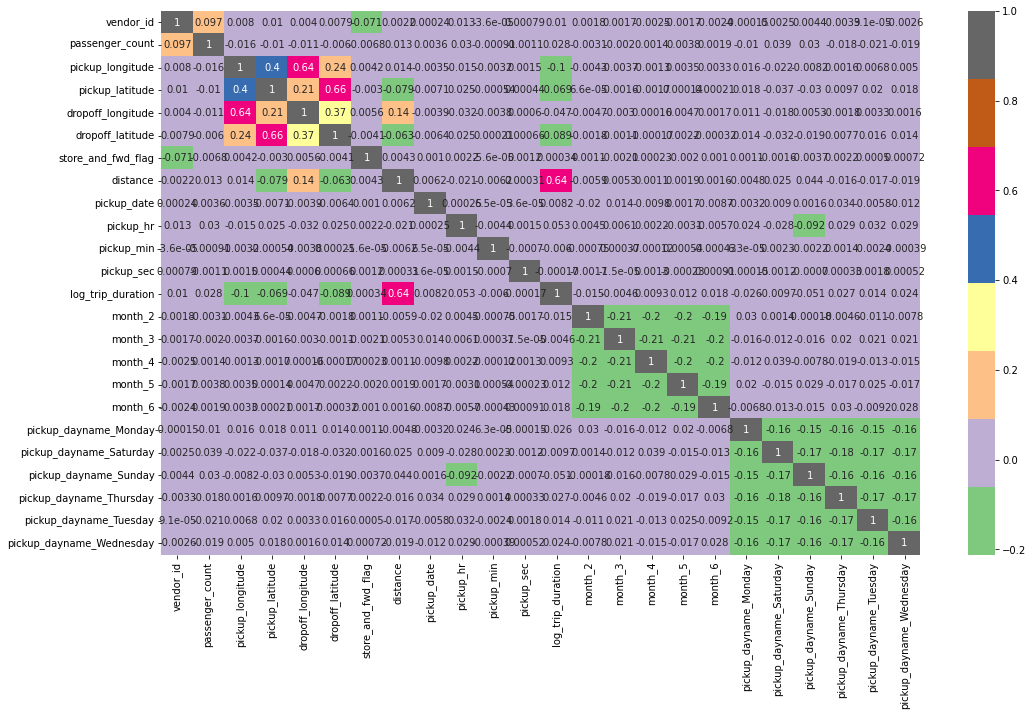

In [91]:
#finding out the correlation between different features 
plt.figure(figsize=(17,10))
sns.heatmap(df.corr(),annot=True,cmap='Accent')

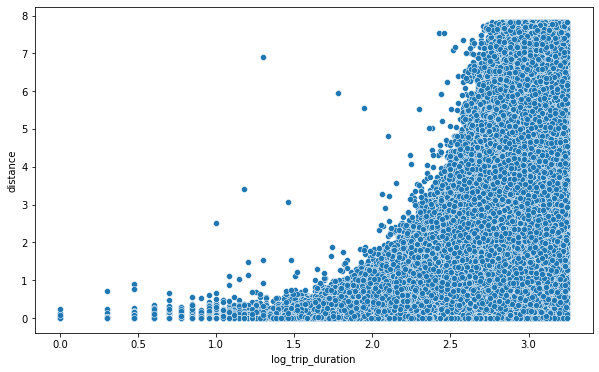

In [25]:
#Bivariate analysis of distance and log of trip duration
fig = plt.figure(figsize=(10, 6))
sns.scatterplot(x='log_trip_duration',y='distance',data=df)

In [ ]:
df

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
0                2                1        -73.982155        40.767937   
1                1                1        -73.980415        40.738564   
3                2                1        -74.010040        40.719971   
4                2                1        -73.973053        40.793209   
5                2                6        -73.982857        40.742195   
...            ...              ...               ...              ...   
1458639          2                4        -73.982201        40.745522   
1458640          1                1        -74.000946        40.747379   
1458641          2                1        -73.959129        40.768799   
1458642          1                1        -73.982079        40.749062   
1458643          1                1        -73.979538        40.781750   

         dropoff_longitude  dropoff_latitude  store_and_fwd_flag  distance  \
0               -73.964630         40.765602                   0  1.498523   
1               -73.999481         40.731152                   0  1.805510   
3               -74.012268         40.706718                   0  1.485501   
4               -73.972923         40.782520                   0  1.188590   
5               -73.992081         40.749184                   0  1.098944   
...                    ...               ...                 ...       ...   
1458639         -73.994911         40.740170                   0  1.225082   
1458640         -73.970184         40.796547                   0  6.049844   
1458641         -74.004433         40.707371                   0  7.824617   
1458642         -73.974632         40.757107                   0  1.092565   
1458643         -73.972809         40.790585                   0  1.134044   

         pickup_date  pickup_hr  ...  month_3  month_4  month_5  month_6  \
0                 14         17  ...        1        0        0        0   
1                 12          0  ...        0        0        0        1   
3                  6         19  ...        0        1        0        0   
4                 26         13  ...        1        0        0        0   
5                 30         22  ...        0        0        0        0   
...              ...        ...  ...      ...      ...      ...      ...   
1458639            8         13  ...        0        1        0        0   
1458640           10          7  ...        0        0        0        0   
1458641           22          6  ...        0        1        0        0   
1458642            5         15  ...        0        0        0        0   
1458643            5         14  ...        0        1        0        0   

         pickup_dayname_Monday  pickup_dayname_Saturday  \
0                            1                        0   
1                            0                        0   
3                            0                        0   
4                            0                        1   
5                            0                        1   
...                        ...                      ...   
1458639                      0                        0   
1458640                      0                        0   
1458641                      0                        0   
1458642                      0                        0   
1458643                      0                        0   

         pickup_dayname_Sunday  pickup_dayname_Thursday  \
0                            0                        0   
1                            1                        0   
3                            0                        0   
4                            0                        0   
5                            0                        0   
...                        ...                      ...   
1458639                      0                        0   
1458640                      1                        0   
1458641                      0

In [ ]:
df.columns

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'distance', 'pickup_date', 'pickup_hr', 'pickup_min', 'pickup_sec',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'pickup_dayname_Monday', 'pickup_dayname_Saturday',
       'pickup_dayname_Sunday', 'pickup_dayname_Thursday',
       'pickup_dayname_Tuesday', 'pickup_dayname_Wednesday',
       'log_trip_duration'],
      dtype='object')

We need to scale the values since the data involves values in different ranges. We can do that by Normalization.

In [92]:
#Choosing the input variables
X=df.loc[: ,['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'distance', 'pickup_date', 'pickup_hr', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'pickup_dayname_Monday',
       'pickup_dayname_Saturday', 'pickup_dayname_Sunday',
       'pickup_dayname_Thursday', 'pickup_dayname_Tuesday',
       'pickup_dayname_Wednesday','pickup_min','pickup_sec']]

In [93]:
#Assigning value of dependent variable to y
y=df.loc[: ,'log_trip_duration']

In [60]:
X

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
0                2                1        -73.982155        40.767937   
1                1                1        -73.980415        40.738564   
3                2                1        -74.010040        40.719971   
4                2                1        -73.973053        40.793209   
7                2                1        -73.969276        40.797779   
...            ...              ...               ...              ...   
1458637          1                1        -73.975357        40.751705   
1458640          1                1        -74.000946        40.747379   
1458641          2                1        -73.959129        40.768799   
1458642          1                1        -73.982079        40.749062   
1458643          1                1        -73.979538        40.781750   

         dropoff_longitude  dropoff_latitude  store_and_fwd_flag  distance  \
0               -73.964630         40.765602                   0  1.498523   
1               -73.999481         40.731152                   0  1.805510   
3               -74.012268         40.706718                   0  1.485501   
4               -73.972923         40.782520                   0  1.188590   
7               -73.922470         40.760559                   0  5.714989   
...                    ...               ...                 ...       ...   
1458637         -73.949478         40.776764                   0  3.537560   
1458640         -73.970184         40.796547                   0  6.049844   
1458641         -74.004433         40.707371                   0  7.824617   
1458642         -73.974632         40.757107                   0  1.092565   
1458643         -73.972809         40.790585                   0  1.134044   

         pickup_date  pickup_hr  ...  month_5  month_6  pickup_dayname_Monday  \
0                 14         17  ...        0        0                      1   
1                 12          0  ...        0        1                      0   
3                  6         19  ...        0        0                      0   
4                 26         13  ...        0        0                      0   
7                 21          7  ...        1        0                      0   
...              ...        ...  ...      ...      ...                    ...   
1458637           17         18  ...        0        0                      0   
1458640           10          7  ...        0        0                      0   
1458641           22          6  ...        0        0                      0   
1458642            5         15  ...        0        0                      0   
1458643            5         14  ...        0        0                      0   

         pickup_dayname_Saturday  pickup_dayname_Sunday  \
0                              0                      0   
1                              0                      1   
3                              0                      0   
4                              1                      0   
7                              1                      0   
...                          ...                    ...   
1458637                        0                      1   
1458640                        0                      1   
1458641                        0                      0   
1458642                        0                      0   
1458643                        0                      0   

         pickup_dayname_Thursday  pickup_dayname_Tuesday  \
0                              0                       0   
1                              0                       0   
3                              0                       0   
4                              0                       0   
7                              0                       0   
...                          ...                     ...   
1458637                        0                       0   
1458640              

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [59]:
X_train

array([[1.        , 0.33333333, 0.18824269, ..., 0.        , 0.15254237,
        0.03389831],
       [0.        , 0.66666667, 0.14926107, ..., 0.        , 0.01694915,
        0.40677966],
       [0.        , 0.33333333, 0.21416669, ..., 0.        , 0.03389831,
        0.79661017],
       ...,
       [0.        , 0.33333333, 0.15718305, ..., 0.        , 0.61016949,
        0.62711864],
       [0.        , 0.33333333, 0.18160461, ..., 0.        , 0.84745763,
        0.        ],
       [1.        , 0.33333333, 0.06569782, ..., 0.        , 0.16949153,
        0.96610169]])

In [34]:
#Shape of each data
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((911613, 23), (227904, 23), (911613,), (227904,))

# **LINEAR REGRESSION**

In [95]:
#importing the class from the library
lr=LinearRegression()

In [96]:
scaler=MinMaxScaler()

In [97]:
#Transforming the input variables
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [98]:
#Fitting the values
lr.fit(X_train,y_train)

LinearRegression()

In [99]:
#predcting y_train
y_pred_train=lr.predict(X_train)

In [100]:
#Predciting y_test
y_pred_test=lr.predict(X_test)

In [101]:
#Best parameters for Linear Regression
lr.get_params()


{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': 'deprecated',
 'positive': False}

In [102]:
#Coefficeints of the best-fit curve
lr.coef_


array([ 4.72956067e-03,  3.11854827e-02, -2.15602851e-01,  1.10963952e-01,
       -3.58210418e-01, -6.90731009e-02, -7.61985444e-03,  9.81924477e-01,
        4.35373347e-03,  5.74252195e-02,  3.90388083e-03,  3.95048288e-03,
        1.72950889e-02,  2.11113228e-02,  2.16605722e-02, -3.46888824e-02,
       -3.75527374e-02, -7.48190148e-02,  8.78247869e-03,  9.82563059e-04,
        8.41473826e-03, -2.98960457e-03, -2.72309457e-04])

In [103]:
# for train data
lr_train_mse  = mean_squared_error((y_train), (y_pred_train))
print("Train MSE :" , lr_train_mse)

lr_train_rmse = lr_train_mse**0.5

print("Train RMSE :" ,lr_train_rmse)

lr_train_r2 = r2_score((y_train), (y_pred_train))
print("Train R2 :" ,lr_train_r2) 

lr_train_r2_adj = 1-(1-r2_score((y_train), (y_pred_train)))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print("Train Adjusted R2 : ",lr_train_r2_adj)

lr_train_mae  = mean_absolute_error((y_train), (y_pred_train))
print("Train Mae :" , lr_train_mae)

Train MSE : 0.04932023150653173
Train RMSE : 0.22208158750002607
Train R2 : 0.44311166200968777
Train Adjusted R2 :  0.4430976113445593
Train Mae : 0.16469601246374665


In [104]:
#for test data
lr_test_mse  = mean_squared_error((y_test), (y_pred_test))
print("Test MSE :" , lr_test_mse)

lr_test_rmse = lr_test_mse**0.5

print("Test RMSE :" ,lr_test_rmse)

lr_test_r2 = r2_score((y_test), (y_pred_test))
print("Test R2 :" ,lr_test_r2)

lr_test_r2_adj = 1-(1-r2_score((y_test), (y_pred_test)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Test Adjusted R2 : ",lr_test_r2_adj)

lr_test_mae  = mean_absolute_error((y_test), (y_pred_test))
print("Test Mae :" , lr_test_mae)


Test MSE : 0.04971509056202676
Test RMSE : 0.22296881073824376
Test R2 : 0.4431515522785241
Test Adjusted R2 :  0.4430953493897335
Test Mae : 0.16494541501954402


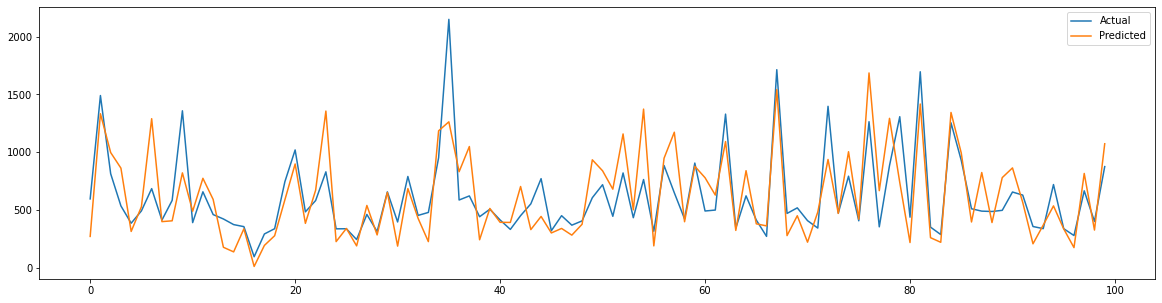

In [105]:
#Plotting actual and predicted values for train data
plt.figure(figsize=(20,5))
plt.plot(10**(y_pred_train)[:100])
plt.plot(np.array(10**(y_train))[:100])
plt.legend(["Actual","Predicted"])
plt.show()

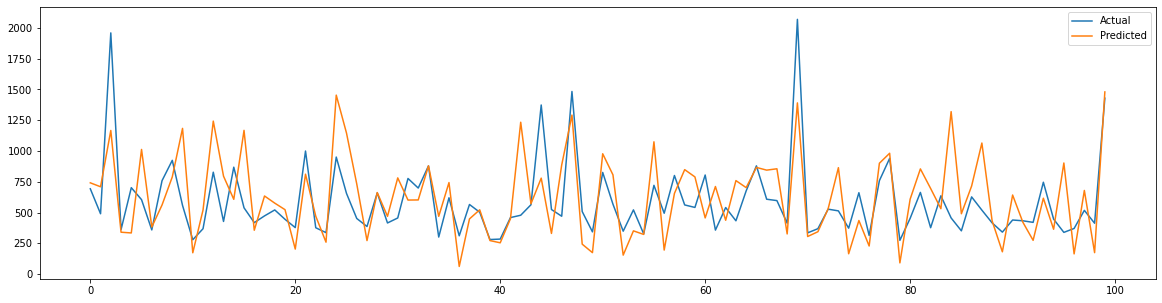

In [106]:
#Plotting actual and predicted values for test data
plt.figure(figsize=(20,5))
plt.plot(10**(y_pred_test)[:100])
plt.plot(np.array(10**(y_test))[:100])
plt.legend(["Actual","Predicted"])
plt.show()

Text(0.5, 1.0, 'Error plot')

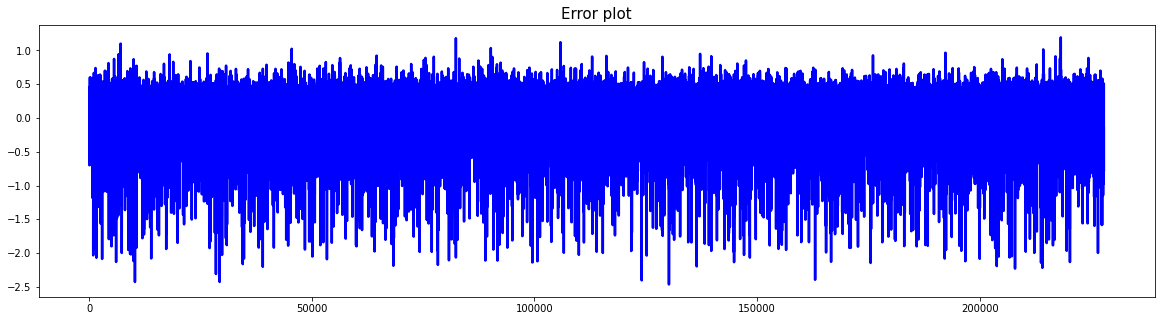

In [107]:
#Plotting the error involved
plt.figure(figsize=(20,5))
c= [i for i in range(0, len(y_test))]

plt.plot(c, y_test-y_pred_test, color='blue', linewidth=2.5, linestyle='-')
plt.title('Error plot', fontsize=15)



# **DECISION TREE**

In [36]:
#importing decisiontree regressor
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor()

In order to find the best parameters we need to perform cross validation.

In [37]:

# Choosing different depths
max_depth = [3,6,9,12]
 
# Choosing minimum number of samples
min_samples_split = [10,20,30]
 
# Choosing the min samples in leaf
min_samples_leaf = [8,16,24]
 
# Hyperparameters
parameters = {'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf}

Since the dataset is large, performing GridSearchCV takes lot of time. Rather we can use HalvingGridSearchCV. By using this, we may compromise on accuracy a little, but the time required for analysis drops exponentially.

In [34]:
#Enabling HalvingGridsearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV



In [39]:
dregressor=HalvingGridSearchCV(dtr,parameters,cv=5,scoring='r2',n_jobs=-1)

In [40]:
#fitting the data
dregressor.fit(X_train,y_train)

HalvingGridSearchCV(estimator=DecisionTreeRegressor(), n_jobs=-1,
                    param_grid={'max_depth': [3, 6, 9, 12],
                                'min_samples_leaf': [8, 16, 24],
                                'min_samples_split': [10, 20, 30]},
                    scoring='r2')

In [41]:
print(f'the best parameters obtained for decision tree are: {dregressor.best_params_} ')
print(f'the best r2 score for these parameters is: {dregressor.best_score_}')

the best parameters obtained for decision tree are: {'max_depth': 12, 'min_samples_leaf': 24, 'min_samples_split': 20} 
the best r2 score for these parameters is: 0.6525024986253802


In [42]:
best_params= {'max_depth': 12, 'min_samples_leaf': 24, 'min_samples_split': 20}

In [44]:
dt_best=dregressor.best_estimator_

In [45]:
#predicting the values
y_pred_train = dt_best.predict(X_train)
y_pred_test = dt_best.predict(X_test)

In [48]:
# for train data
dt_train_mse  = mean_squared_error((y_train), (y_pred_train))
print("Train MSE :" , dt_train_mse)

dt_train_rmse = dt_train_mse**0.5

print("Train RMSE :" ,dt_train_rmse)

dt_train_r2 = r2_score((y_train), (y_pred_train))
print("Train R2 :" ,dt_train_r2) 

dt_train_r2_adj = 1-(1-r2_score((y_train), (y_pred_train)))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print("Train Adjusted R2 : ",dt_train_r2_adj)

dt_train_mae  = mean_absolute_error((y_train), (y_pred_train))
print("Train MAE :" , dt_train_mae)

Train MSE : 0.028960382438989934
Train RMSE : 0.17017750274049134
Train R2 : 0.6730003337093611
Train Adjusted R2 :  0.6729920832891336
Train MAE : 0.12402443917112588


In [49]:
#for test data
dt_test_mse  = mean_squared_error((y_test), (y_pred_test))
print("Test MSE :" , dt_test_mse)

dt_test_rmse = dt_test_mse**0.5

print("Test RMSE :" ,dt_test_rmse)

dt_test_r2 = r2_score((y_test), (y_pred_test))
print("Test R2 :" ,dt_test_r2)

dt_test_r2_adj = 1-(1-r2_score((y_test), (y_pred_test)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Test Adjusted R2 : ",dt_test_r2_adj)

dt_test_mae  = mean_absolute_error((y_test), (y_pred_test))
print("Test Mae :" , dt_test_mae)

Test MSE : 0.030947810512389613
Test RMSE : 0.17591989800016827
Test R2 : 0.6533599748208933
Test Adjusted R2 :  0.6533249883342374
Test Mae : 0.12723366403047393


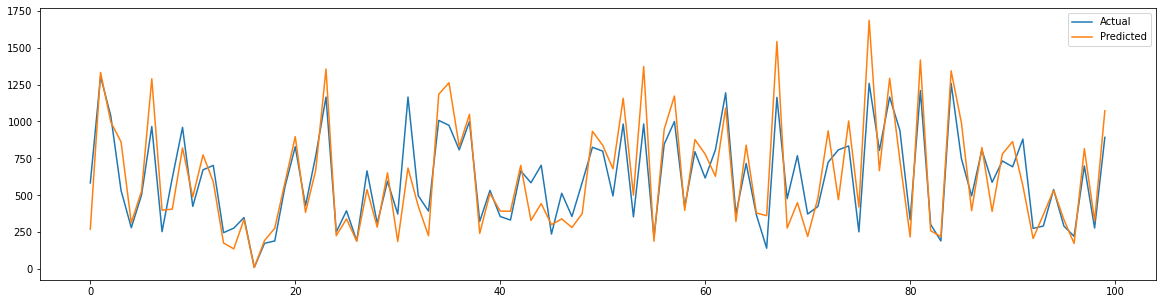

In [49]:
#Plotting actual and predicted values for train data
plt.figure(figsize=(20,5))
plt.plot(10**(y_pred_train)[:100])
plt.plot(np.array(10**(y_train))[:100])
plt.legend(["Actual","Predicted"])
plt.show()

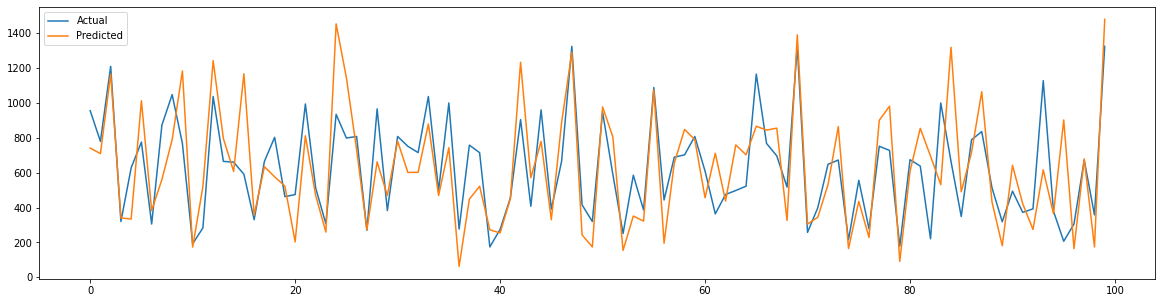

In [50]:
#Plotting actual and predicted values for test data
plt.figure(figsize=(20,5))
plt.plot(10**(y_pred_test)[:100])
plt.plot(np.array(10**(y_test))[:100])
plt.legend(["Actual","Predicted"])
plt.show()

Text(0.5, 1.0, 'Error plot')

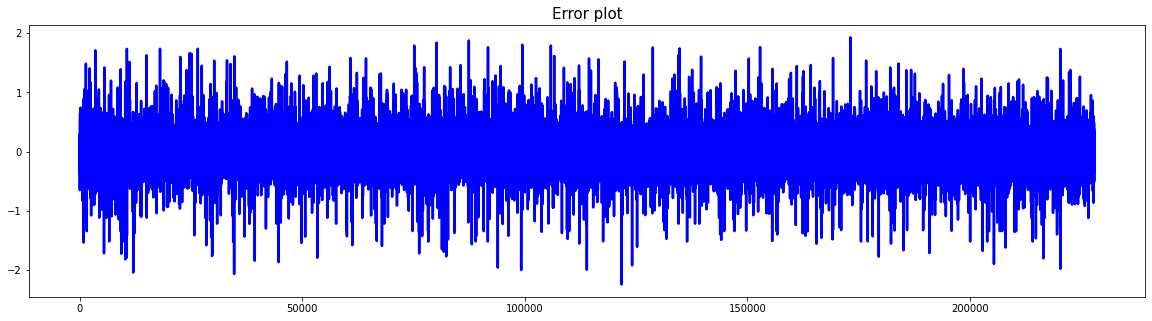

In [51]:
#plotting the error
plt.figure(figsize=(20,5))
c= [i for i in range(0, len(y_test))]

plt.plot(c, y_test-y_pred_test, color='blue', linewidth=2.5, linestyle='-')
plt.title('Error plot', fontsize=15)

In [52]:
dt_best.feature_importances_

array([1.01015270e-02, 1.04780136e-03, 1.08852573e-02, 6.79485021e-03,
       1.59280815e-02, 4.84240127e-02, 0.00000000e+00, 8.14673112e-01,
       9.88926804e-04, 6.58159648e-02, 5.37941224e-06, 4.89817819e-05,
       9.72802481e-05, 3.67587480e-05, 1.27473819e-04, 1.99130498e-03,
       8.04686366e-03, 1.18115247e-02, 2.26244007e-05, 6.02705704e-04,
       2.41046692e-04, 1.65674040e-03, 6.51781345e-04])

In [61]:
importances = dt_best.feature_importances_

importance_dict = {'Feature' : list(X.columns),
                   'Feature Importance' : importances}

importance_df = pd.DataFrame(importance_dict)

In [69]:
importance_df.sort_values('Feature Importance',ascending=False,inplace=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

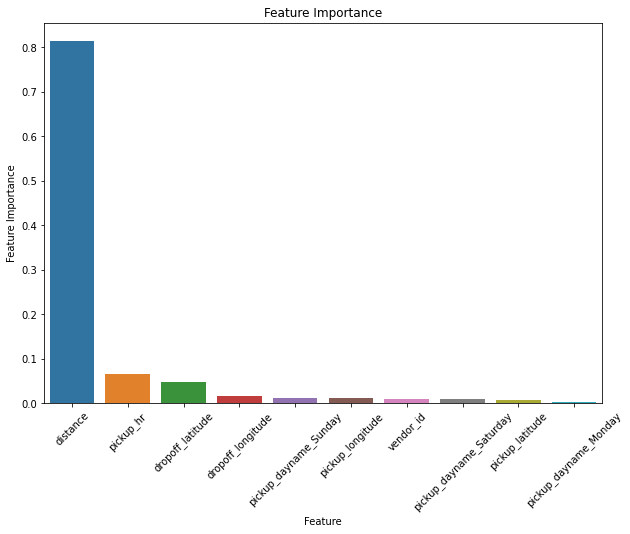

In [76]:
plt.figure(figsize=(10,7))
sns.barplot(data=importance_df[:10], y='Feature Importance',x='Feature')
plt.title('Feature Importance')
plt.xticks(rotation=45)

# **REGULARIZED LINEAR REGRESSON- LASSO**

In [108]:
#performing cross validation
lasso = Lasso()
parameters = {'alpha': [1e-15,1e-12,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1e-1,1,5,10,20,30,40,45,50,55,75,100]}
lasso_regressor =GridSearchCV(lasso, parameters, scoring='r2', cv=5,n_jobs=-1)
lasso_regressor.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': [1e-15, 1e-12, 1e-10, 1e-08, 1e-05, 0.0001,
                                   0.001, 0.01, 0.1, 1, 5, 10, 20, 30, 40, 45,
                                   50, 55, 75, 100]},
             scoring='r2')

In [109]:
print(f'The best parameters for lasso regression are: {lasso_regressor.best_params_}')
print(f'The r2 score obtained from these parameters is: {lasso_regressor.best_score_}')

The best parameters for lasso regression are: {'alpha': 1e-15}
The r2 score obtained from these parameters is: 0.44306979292846255


In [110]:
#predicting the values
y_pred_train = lasso_regressor.predict(X_train)
y_pred_test = lasso_regressor.predict(X_test)

In [111]:
# for train data
lasso_train_mse  = mean_squared_error((y_train), (y_pred_train))
print("Train MSE :" , lasso_train_mse)

lasso_train_rmse = lasso_train_mse**0.5

print("Train RMSE :" ,lasso_train_rmse)

lasso_train_r2 = r2_score((y_train), (y_pred_train))
print("Train R2 :" ,lasso_train_r2) 

lasso_train_r2_adj = 1-(1-r2_score((y_train), (y_pred_train)))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print("Train Adjusted R2 : ",lasso_train_r2_adj)

lasso_train_mae  = mean_absolute_error((y_train), (y_pred_train))
print("Train MAE :" , lasso_train_mae)

Train MSE : 0.04932023150653175
Train RMSE : 0.2220815875000261
Train R2 : 0.44311166200968755
Train Adjusted R2 :  0.44309761134455905
Train MAE : 0.16469601246374582


In [113]:
#for test data
lasso_test_mse  = mean_squared_error((y_test), (y_pred_test))
print("Test MSE :" , lasso_test_mse)

lasso_test_rmse = lasso_test_mse**0.5
print("Test RMSE :" ,lasso_test_rmse)

lasso_test_r2 = r2_score((y_test), (y_pred_test))
print("Test R2 :" ,lasso_test_r2)

lasso_test_r2_adj = 1-(1-r2_score((y_test), (y_pred_test)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Test Adjusted R2 : ",lasso_test_r2_adj)

lasso_test_mae  = mean_absolute_error((y_test), (y_pred_test))
print("Test MAE :" , lasso_test_mae)

Test MSE : 0.049715090562026755
Test RMSE : 0.22296881073824373
Test R2 : 0.4431515522785242
Test Adjusted R2 :  0.4430953493897336
Test MAE : 0.16494541501954332


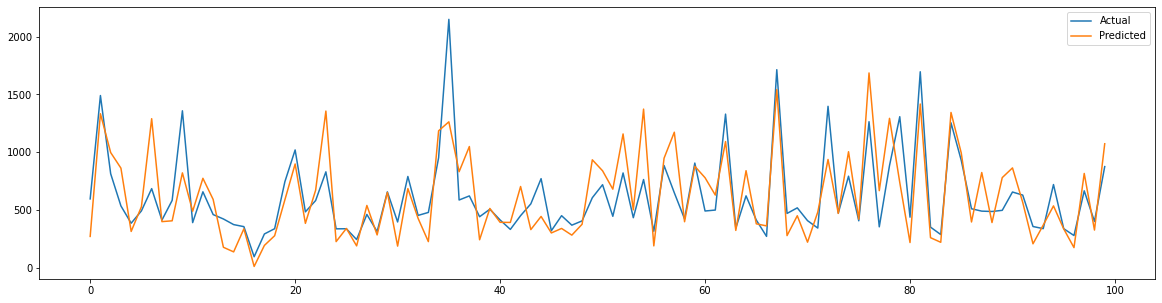

In [114]:
#Plotting actual and predicted values for train data
plt.figure(figsize=(20,5))
plt.plot(10**(y_pred_train)[:100])
plt.plot(np.array(10**(y_train))[:100])
plt.legend(["Actual","Predicted"])
plt.show()

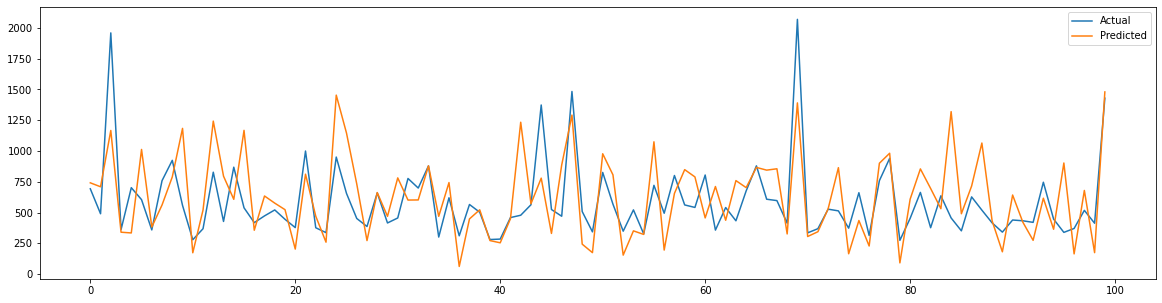

In [115]:
#Plotting actual and predicted values for test data
plt.figure(figsize=(20,5))
plt.plot(10**(y_pred_test)[:100])
plt.plot(np.array(10**(y_test))[:100])
plt.legend(["Actual","Predicted"])
plt.show()

Text(0.5, 1.0, 'Error plot')

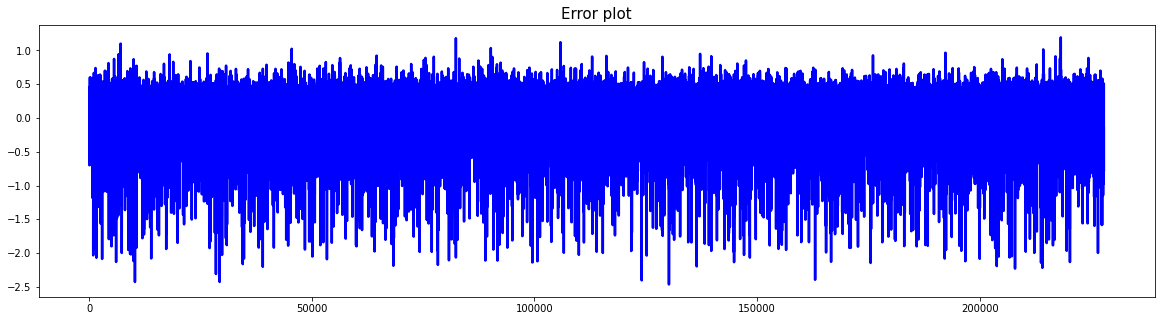

In [116]:
#plotting the error
plt.figure(figsize=(20,5))
c= [i for i in range(0, len(y_test))]

plt.plot(c, y_test-y_pred_test, color='blue', linewidth=2.5, linestyle='-')
plt.title('Error plot', fontsize=15)

# **REGULARIZED LINEAR REGRESSON- RIDGE**

In [117]:
#Performing Cross Validation
ridge = Ridge()
parameters = {'alpha': [1e-15,1e-12,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1e-1,1,5,10,20,30,40,45,50,55,75,100]}
ridge_regressor = GridSearchCV(ridge, parameters, scoring='r2', cv=5,n_jobs=-1)
ridge_regressor.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [1e-15, 1e-12, 1e-10, 1e-08, 1e-05, 0.0001,
                                   0.001, 0.01, 0.1, 1, 5, 10, 20, 30, 40, 45,
                                   50, 55, 75, 100]},
             scoring='r2')

In [118]:
print(f'The best parameters for ridge regression is: {ridge_regressor.best_params_}')
print(f'The r2 score obtained using the above parameter is: {ridge_regressor.best_score_}')


The best parameters for ridge regression is: {'alpha': 1}
The r2 score obtained using the above parameter is: 0.4430697958491388


In [119]:
#Predicting the values
y_pred_train = ridge_regressor.predict(X_train)
y_pred_test = ridge_regressor.predict(X_test)

In [120]:
# for train data
ridge_train_mse  = mean_squared_error((y_train), (y_pred_train))
print("Train MSE :" , ridge_train_mse)

ridge_train_rmse = ridge_train_mse**0.5

print("Train RMSE :" ,ridge_train_rmse)

ridge_train_r2 = r2_score((y_train), (y_pred_train))
print("Train R2 :" ,ridge_train_r2) 

ridge_train_r2_adj = 1-(1-r2_score((y_train), (y_pred_train)))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print("Train Adjusted R2 : ",ridge_train_r2_adj)

ridge_train_mae  = mean_absolute_error((y_train), (y_pred_train))
print("Train MAE :" , ridge_train_mae)

Train MSE : 0.04932023157583132
Train RMSE : 0.22208158765604888
Train R2 : 0.443111661227207
Train Adjusted R2 :  0.44309761056205876
Train MAE : 0.16469559052124447


In [121]:
#for test data
ridge_test_mse  = mean_squared_error((y_test), (y_pred_test))
print("Test MSE :" , ridge_test_mse)

ridge_test_rmse = ridge_test_mse**0.5

print("Test RMSE :" ,ridge_test_rmse)

ridge_test_r2 = r2_score((y_test), (y_pred_test))
print("Test R2 :" ,ridge_test_r2)

ridge_test_r2_adj = 1-(1-r2_score((y_test), (y_pred_test)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Test Adjusted R2 : ",ridge_test_r2_adj)

ridge_test_mae  = mean_absolute_error((y_test), (y_pred_test))
print("Test MAE :" , ridge_test_mae)

Test MSE : 0.04971509769033181
Test RMSE : 0.22296882672322563
Test R2 : 0.4431514724358535
Test Adjusted R2 :  0.44309526953900435
Test MAE : 0.1649450065140476


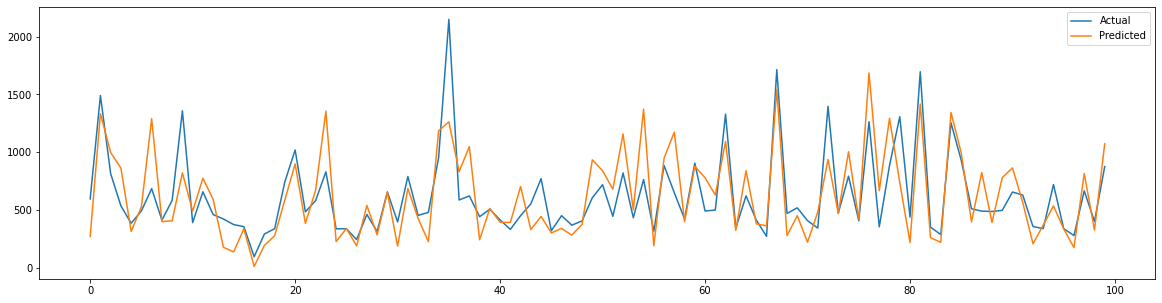

In [122]:
#Plotting actual and predicted values for train data
plt.figure(figsize=(20,5))
plt.plot(10**(y_pred_train)[:100])
plt.plot(np.array(10**(y_train))[:100])
plt.legend(["Actual","Predicted"])
plt.show()

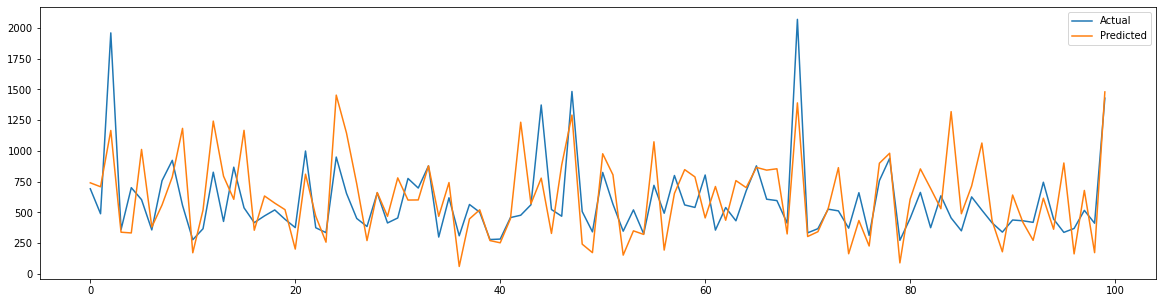

In [123]:
#Plotting actual and predicted values for test data
plt.figure(figsize=(20,5))
plt.plot(10**(y_pred_test)[:100])
plt.plot(np.array(10**(y_test))[:100])
plt.legend(["Actual","Predicted"])
plt.show()

Text(0.5, 1.0, 'Error plot')

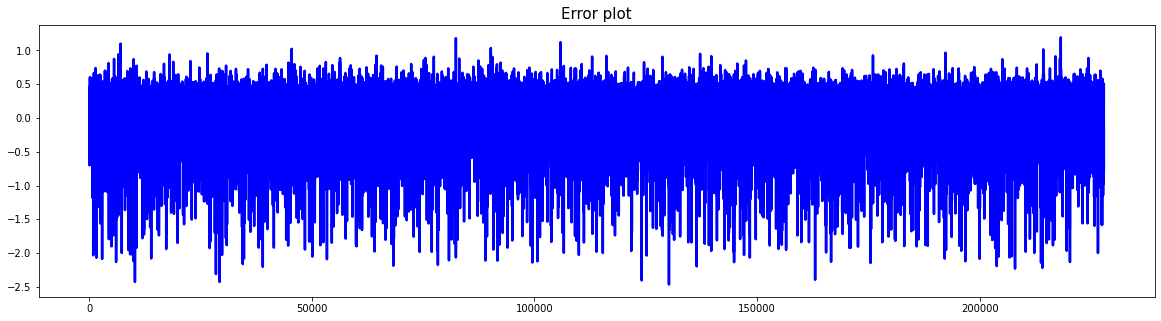

In [124]:
# plotting the error
plt.figure(figsize=(20,5))
c= [i for i in range(0, len(y_test))]

plt.plot(c, y_test-y_pred_test, color='blue', linewidth=2.5, linestyle='-')
plt.title('Error plot', fontsize=15)

# **Xgboost**

It stands for Extreme Gradient boosting. This method involves training a number of trees subsequently, giving consideration for the errors of the previous model.

In [139]:
#importing xgboost
import xgboost as xgb

In [132]:
# No of estimators
n_estimators = [80,100]
 
# Maximum depth of trees
max_depth = [6,10]
# samples split
min_samples_split = [40,50]
#different learning rates
learning_rate=[0.1,0.2,0.4]
 
# Hyperparameter Grid
xgb_params = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
             'min_samples_' : min_samples_split,
             'learning_rate' : learning_rate
             }
#after tuning best parametres were
best_params={'learning_rate': [0.2],
 'max_depth': [10],
 'min_samples_': [40],
 'n_estimators': [100]}


In [140]:
xgb_model = xgb.XGBRegressor(tree_method = 'hist',silent=1)


In [141]:
xgb_grid = GridSearchCV(estimator=xgb_model,
                        param_grid = best_params,
                        cv = 3, verbose=1,
                        scoring="r2")

In [142]:
xgb_grid.fit(X_train,y_train)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=3, estimator=XGBRegressor(silent=1, tree_method='hist'),
             param_grid={'learning_rate': [0.2], 'max_depth': [10],
                         'min_samples_': [40], 'n_estimators': [100]},
             scoring='r2', verbose=1)

In [143]:
#best score for train values
xgb_grid.score(X_train,y_train)

0.8173124761887547

In [144]:
# predicting train values
y_pred_train = xgb_grid.predict(X_train)
y_pred_test = xgb_grid.predict(X_test)

In [145]:
#bestscore for test values
xgb_grid.score(X_test, y_test)

0.7343754858361997

In [146]:
# for train data
xgb_train_mse  = mean_squared_error((y_train), (y_pred_train))
print("Train MSE :" , xgb_train_mse)

xgb_train_rmse = xgb_train_mse**0.5

print("Train RMSE :" ,xgb_train_rmse)

xgb_train_r2 = r2_score((y_train), (y_pred_train))
print("Train R2 :" ,xgb_train_r2) 

xgb_train_r2_adj = 1-(1-r2_score((y_train), (y_pred_train)))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print("Train Adjusted R2 : ",xgb_train_r2_adj)

xgb_train_mae  = mean_absolute_error((y_train), (y_pred_train))
print("Train MAE :" , xgb_train_mae)

Train MSE : 0.016179528916409794
Train RMSE : 0.1271987771812677
Train R2 : 0.8173124761887547
Train Adjusted R2 :  0.8173078668603757
Train MAE : 0.09224975411412556


In [147]:
#for test data
xgb_test_mse  = mean_squared_error((y_test), (y_pred_test))
print("Test MSE :" , xgb_test_mse)

xgb_test_rmse = xgb_test_mse**0.5

print("Test RMSE :" ,xgb_test_rmse)

xgb_test_r2 = r2_score((y_test), (y_pred_test))
print("Test R2 :" ,xgb_test_r2)

xgb_test_r2_adj = 1-(1-r2_score((y_test), (y_pred_test)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Test Adjusted R2 : ",xgb_test_r2_adj)

xgb_test_mae  = mean_absolute_error((y_test), (y_pred_test))
print("Test Mae :" , xgb_test_mae)

Test MSE : 0.023714794988084143
Test RMSE : 0.1539960875739515
Test R2 : 0.7343754858361997
Test Adjusted R2 :  0.7343486762705258
Test Mae : 0.10364043933747706


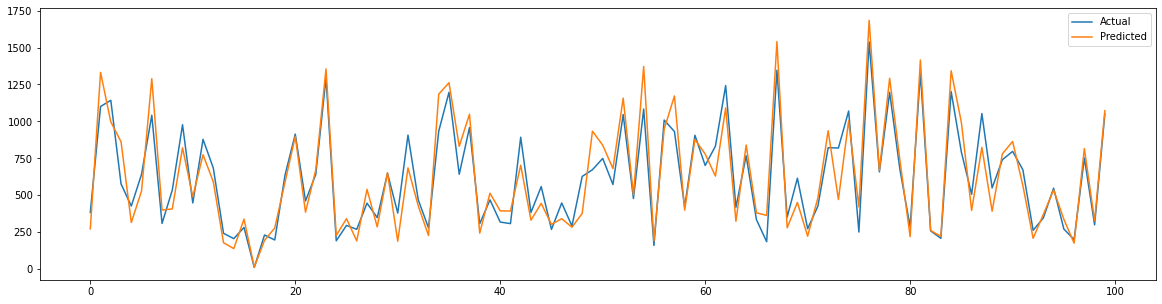

In [148]:
#Plotting actual and predicted values for train data
plt.figure(figsize=(20,5))
plt.plot(10**(y_pred_train)[:100])
plt.plot(np.array(10**(y_train))[:100])
plt.legend(["Actual","Predicted"])
plt.show()

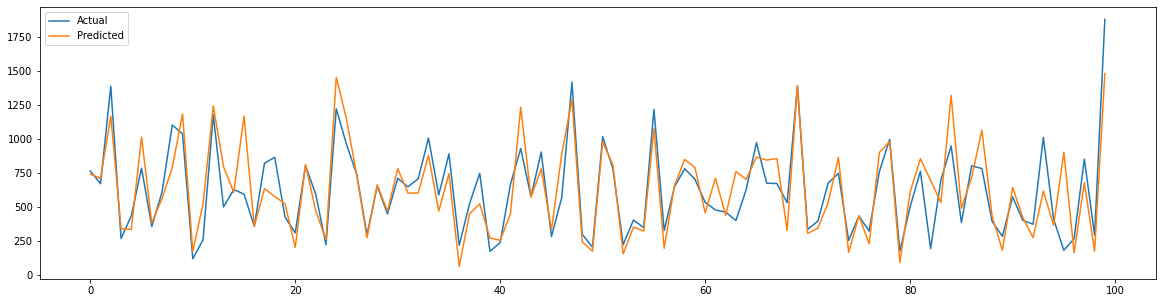

In [149]:
#Plotting actual and predicted values for test data
plt.figure(figsize=(20,5))
plt.plot(10**(y_pred_test)[:100])
plt.plot(np.array(10**(y_test))[:100])
plt.legend(["Actual","Predicted"])
plt.show()

Text(0.5, 1.0, 'Error plot')

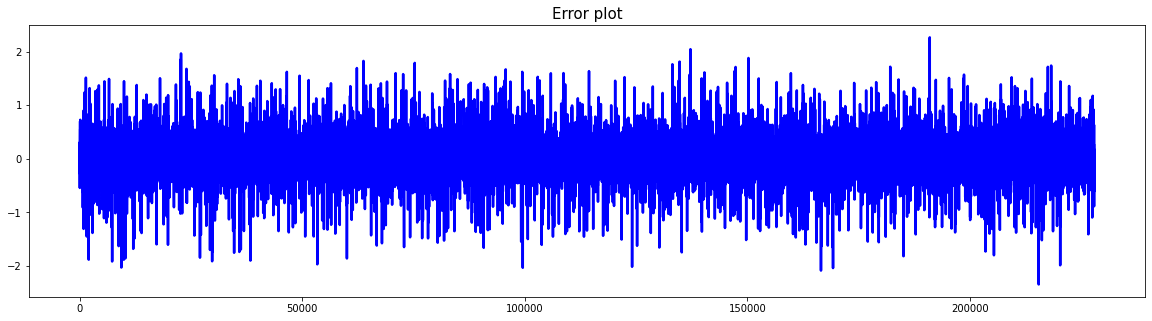

In [150]:
# plotting the error
plt.figure(figsize=(20,5))
c= [i for i in range(0, len(y_test))]

plt.plot(c, y_test-y_pred_test, color='blue', linewidth=2.5, linestyle='-')
plt.title('Error plot', fontsize=15)

In [151]:
best_xgb=xgb_grid.best_estimator_

In [152]:
#feature importances
best_xgb.feature_importances_

array([0.04130511, 0.01401443, 0.01963351, 0.02054295, 0.0225236 ,
       0.04194176, 0.01209272, 0.42556712, 0.01458022, 0.0635923 ,
       0.01833601, 0.01858985, 0.01870103, 0.01427708, 0.01732071,
       0.03751011, 0.05717439, 0.07034553, 0.01514308, 0.01787851,
       0.01611088, 0.01168559, 0.01113341], dtype=float32)

In [153]:

importances = best_xgb.feature_importances_

importance_dict = {'Feature' : list(X.columns),
                   'Feature Importance' : importances}

importance_df = pd.DataFrame(importance_dict)

In [154]:
importance_df.sort_values('Feature Importance',ascending=False,inplace=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

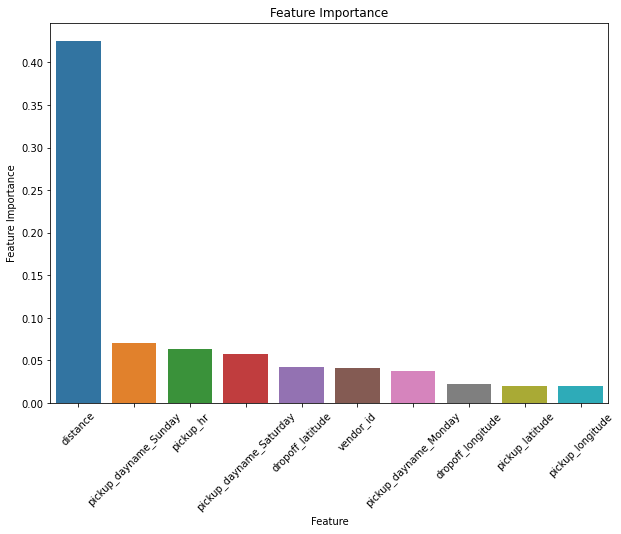

In [155]:
#plotting the feature importances
plt.figure(figsize=(10,7))
sns.barplot(data=importance_df[:10], y='Feature Importance',x='Feature')
plt.title('Feature Importance')
plt.xticks(rotation=45)

# CONCLUSION

*   For this regression problem, linear models such as Linear Regression, Lasso Regression, Ridge Regression performed poorly in comparison with other models.
*   The performance of Linear Regression has not  improved when it is used with Ridge Regularization, and Lasso Regularization.

*   Decision Tree performed fairly better when compared with linear models.
*   XGBoost has the best values of MSE, MAE,R2Score for both training and testing data.

*   According to decision tree, Distance and pickup_hr are the most important features whereas Distance and Pickup_dayname_Sunday are the most important features as per XGBoost.
*   We can effectively use XGBoost model to predict the taxi trip time .





